In [ ]:
!pip install tensorflow==2.8.3
import tensorflow as tf
import numpy as np
import os
import random
import tensorboard
import datetime

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 497.9 MB 33 kB/s 
     |████████████████████████████████| 5.8 MB 55.9 MB/s 
     |████████████████████████████████| 1.4 MB 52.4 MB/s 
     |████████████████████████████████| 462 kB 70.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully un

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Random seed for reproducibility
seed = 54721

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
%cd /content/drive/MyDrive/ANN&DL
dataset_dir = 'training_data_final'
image_size = 96
# image_size = 331
batch_size = 64

/content/drive/MyDrive/ANN&DL


In [ ]:
class_names = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']
class_samples = [0] * len(class_names)

In [ ]:
for i, class_name in enumerate(class_names):
    class_dir = '{}/{}/'.format(dataset_dir, class_name)
    class_samples[i] = len(os.listdir(class_dir))

In [ ]:
total_samples = sum(class_samples)
class_weight = list(total_samples / (len(class_names) * np.array(class_samples)))
class_weight = {i: class_weight[i] for i in range(len(class_weight))}

In [ ]:
print('Class weights: {}'.format(class_weight))

Class weights: {0: 2.3803763440860215, 1: 0.8322368421052632, 2: 0.8597087378640776, 3: 0.8664383561643836, 4: 0.833804143126177, 5: 1.9943693693693694, 6: 0.824487895716946, 7: 0.8715551181102362}


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    shuffle=True,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 3542 files belonging to 8 classes.
Using 2834 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 3542 files belonging to 8 classes.
Using 708 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [ ]:
# Add caching to dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Use one-hot encoding for labels
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

In [ ]:
crop_dim = 3
input_shape = (image_size, image_size, 3)
input_shape_cropping = (image_size-crop_dim*2, image_size-crop_dim*2, 3)

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet')
base_model.trainable = True

35848192/35839040 [==============================] - 0s 0us/step


In [ ]:
model = tfk.Sequential([
    tfk.layers.Input(shape=input_shape),
    # Augmentation
    tfk.layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
    # tfk.layers.RandomRotation(0.5),
    tfk.layers.RandomZoom(0.5),
    tfk.layers.RandomTranslation(width_factor=0.5, height_factor=0.5),
    tfk.layers.Cropping2D(cropping=((crop_dim, crop_dim), (crop_dim, crop_dim)), input_shape=input_shape),

    tf.keras.layers.Resizing(height=image_size, width=image_size, interpolation='bilinear', crop_to_aspect_ratio=False),
    
    # Preprocess for base model
    tfk.layers.Lambda(tf.keras.applications.efficientnet_v2.preprocess_input),
    # Transfer learning
    base_model,
    # Global avg
    # tfk.layers.Flatten(),

    tfk.layers.GlobalAveragePooling2D(),

    # Classification
    # tfk.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    tfk.layers.Dense(192, activation='relu', kernel_initializer='he_uniform'),
    tfk.layers.Dense(48, activation='relu', kernel_initializer='he_uniform'),
    # Dropout
    tfk.layers.Dropout(0.3),
    # Output
    tfk.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer=tfk.optimizers.Adagrad(learning_rate=0.01, initial_accumulator_value=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 96, 96, 3)         0         
                                                                 
 random_zoom (RandomZoom)    (None, 96, 96, 3)         0         
                                                                 
 random_translation (RandomT  (None, 96, 96, 3)        0         
 ranslation)                                                     
                                                                 
 cropping2d (Cropping2D)     (None, 90, 90, 3)         0         
                                                                 
 resizing (Resizing)         (None, 96, 96, 3)         0         
                                                                 
 lambda (Lambda)             (None, 96, 96, 3)         0         
                                                        

In [ ]:
epochs = 200

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weight,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
    ).history

Epoch 1/200
45/45 [==============================] - 257s 4s/step - loss: 2.0561 - accuracy: 0.1754 - val_loss: 2.0010 - val_accuracy: 0.1983
Epoch 2/200
45/45 [==============================] - 7s 154ms/step - loss: 1.9323 - accuracy: 0.2438 - val_loss: 1.8929 - val_accuracy: 0.2828
Epoch 3/200
45/45 [==============================] - 8s 155ms/step - loss: 1.7653 - accuracy: 0.3296 - val_loss: 1.7587 - val_accuracy: 0.3655
Epoch 4/200
45/45 [==============================] - 8s 154ms/step - loss: 1.6191 - accuracy: 0.3899 - val_loss: 1.6263 - val_accuracy: 0.4190
Epoch 5/200
45/45 [==============================] - 8s 156ms/step - loss: 1.4725 - accuracy: 0.4524 - val_loss: 1.4787 - val_accuracy: 0.4690
Epoch 6/200
45/45 [==============================] - 8s 155ms/step - loss: 1.3814 - accuracy: 0.4884 - val_loss: 1.3957 - val_accuracy: 0.4948
Epoch 7/200
45/45 [==============================] - 8s 154ms/step - loss: 1.3232 - accuracy: 0.5141 - val_loss: 1.3408 - val_accuracy: 0.5431


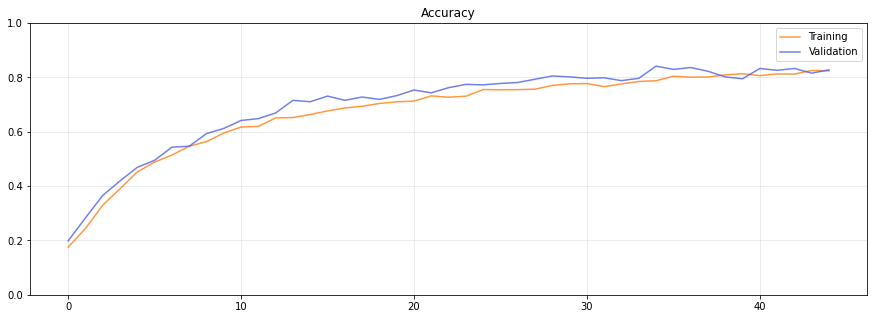

In [ ]:
import matplotlib.pyplot as plt

# plot the trend of the MSE of the training set (always decreasing of course) and of the validation set
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)
print("Loss", loss)

2/2 [==============================] - 1s 66ms/step - loss: 0.3927 - accuracy: 0.8750
Accuracy 0.875
Loss 0.3926621675491333


In [ ]:
# Save best epoch model
model.save("V2B2_1")